**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №4. Критерии принятия решения и метрики качества**

**Цель работы:** изучение основных критериев принятия решения и метрик качества, рассматриваемых при решении задачи голосовой биометрии.

**Краткое описание:** в рамках настоящей лабораторной работы предлагается изучить и реализовать классические критерии принятия решения (критерий максимального правдоподобия, критерий максимума апостериорной вероятности, критерий Неймана-Пирсона, критерий Байеса и минимаксный критерий), позволяющие автоматически подобрать порог принятия решения для биометрической системы, а также оценить качество полученных биометрических решений по целевым метрикам.

**Данные:** в качестве данных для выполнения лабораторной работы предлагается использовать тестовую часть базы [VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).

**Содержание лабораторной работы**

1. Подготовка тестовых данных и протокола для проведения тестирования системы верификации диктора.							

2. Вычисление дикторских моделей для эталонных и тестовых звукозаписей используемого протокола.

3. Формирование оценок сравнения эталонных и тестовых дикторских моделей.

4. Построение таргет- и импостор-гистограмм оценок сравнения моделей.

5. Вычисление порогового значения, вероятности ошибки принятия решения, вероятностей ошибок первого и второго рода: критерий максимального правдоподобия, критерий максимума апостериорной вероятности (критерий минимума вероятности ошибки), критерий Неймана-Пирсона, критерий Байеса и минимаксный критерий.

6. Вычисление значения равновероятной ошибки (EER, equal error rate).							

In [1]:
# IPython extension to reload modules before executing user code
%load_ext autoreload
%autoreload 2

# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

from math import sqrt, pi

import numpy as np
from matplotlib.pyplot import hist, plot, show, grid, title, xlabel, ylabel, legend, axis, imshow
import torch
from torch.utils.data import DataLoader
import itertools

from common import download_dataset, extract_dataset, download_protocol
from common import test_dataset_loader
from common import get_eer
from common import extract_features, compute_scores
from LoadModel import load_model
from ResNetSE34V2 import MainModel
from exercises_blank import tar_imp_hists, llr, map_test, neyman_pearson_test, bayes_test, minmax_test

/home/kirilabrosimov/anaconda3/envs/sr_labs_book/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1. Подготовка тестовых данных и протокола для проведения тестирования системы верификации диктора**

В ходе выполнения лабораторной работы необходимы *тестовые данные*, а также связанный с ними *протокол тестирования*. Данные представляют собой звукозаписи голосов людей мужского и женского пола, сохраненных в формат *wav*. Протокол тестирования организован в виде текстового файла, в каждой строчке которого содержится одна таргет- или импостор-попытка сравнения эталонной и тестовой звукозаписи (рассматривается задача *верификации диктора*, т.е. сравнение «один к одному»). Голоса эталона и теста из *таргет-попытки* (метка «1») соответствуют одному и тому же диктору, а голоса эталона и теста из *импостор-попытки* (метка «0») соответствуют разным дикторам.

Необходимые данные можно скачать по ссылкам, представленным ниже:

1. Выполнить загрузку и распаковку звуковых wav-файлов базы [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip).

2. Выполнить загрузку протокола тестирования [VoxCeleb1-O cleaned](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/meta/veri_test2.txt).

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# Download VoxCeleb1 (test set)
with open('../data/lists/datasets.txt', 'r') as f:
    lines = f.readlines()

download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

Checksum successful vox1_test_wav.zip.


In [3]:
# Extract VoxCeleb1 test set
extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')

Extracting of ../data/vox1_test_wav.zip is successful.


In [4]:
# Download VoxCeleb1-O cleaned protocol
with open('../data/lists/protocols.txt', 'r') as f:
    lines = f.readlines()
    
download_protocol(lines, save_path='../data/voxceleb1_test')

File veri_test2.txt is downloaded.


**2. Вычисление дикторских моделей для эталонных и тестовых звукозаписей используемого протокола**

Эталонные и тестовые звукозаписи таргет- и импостор-попыток из тестового протокола неудобно сравнивать «в лоб». Рассматриваемые в лабораторной работе данные содержат звукозаписи с *частотой дискретизации* 16кГц. Последнее означает, что в 1 секунде записи содержится 16,000 отсчётов *цифрового сигнала*, а в двух секундах – 32,000 и т.п. Сравнивать между собой длинные вектора не самая удачная идея, т.к. это затратно в смысле вычислительной сложности. Дополнительно необходимо отметить, что «сырой» звуковой сигнал содержит не только голос диктора, а помехи и шумы, акустику помещения и т.п. Поэтому на практике при решении задачи распознавания диктора для эталонной и тестовой звукозаписи вычисляется *дикторская модель*, содержащая внутри себя основные характеристик голоса конкретного диктора. Построить дикторскую модель можно различными способами, например, с использованием специально обученной искусственной нейронной сети, на вход которой передаётся набор акустических признаков, вычисленных для определенной звукозаписи, а на выходе формируется вектор малой размерности, например, длины 128, 256 и т.п. Этот вектор, иногда называемый *эмбеддингом*, и является дикторской моделью.

Ниже представлена последовательность действий, которую необходимо выполнить при рассмотрении настоящего пункта:

1. Описать и инициализировать модель для генерации дикторских эмбеддингов.

2. Вгрузить в инициализированную модель обученные веса.

3. Вычислить эмбеддинги для протокольных эталонных и тестовых звукозаписей.

In [2]:
import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    # 3x3 convolution with padding

    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    # 1x1 convolution
    
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    # Create basic ResNet block

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, norm_layer=None, activation=nn.ReLU):
        
        super(BasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1      = conv3x3(inplanes, planes, stride)
        self.bn1        = norm_layer(planes)
        self.relu       = activation(inplace=True)
        self.conv2      = conv3x3(planes, planes)
        self.bn2        = norm_layer(planes)
        self.downsample = downsample
        self.stride     = stride

    def forward(self, x):
        
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class MaxoutLinear(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MaxoutLinear, self).__init__()
        self.linear1 = nn.Linear(*args, **kwargs)
        self.linear2 = nn.Linear(*args, **kwargs)

    def forward(self, x):
        return torch.max(self.linear1(x), self.linear2(x))

    
class ResNet(nn.Module):
    # ResNet model for speaker recognition

    def __init__(self, block, layers, activation, num_filters, nOut, encoder_type='SP', n_mels=64, log_input=True, **kwargs):
        super(ResNet, self).__init__()
        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        self.inplanes     = num_filters[0]
        self.encoder_type = encoder_type
        self.n_mels       = n_mels
        self.log_input    = log_input
        self.torchfb      = torch.nn.Sequential(PreEmphasis(), 
                                                  torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                                                       n_fft=512, 
                                                                                       win_length=400, 
                                                                                       hop_length=160, 
                                                                                       window_fn=torch.hamming_window, 
                                                                                       n_mels=n_mels))
        self.instancenorm   = nn.InstanceNorm1d(n_mels)
        self.conv1  = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(num_filters[0])
        self.relu   = activation(inplace=True)
#         self.relu   = activation()
        self.layer1 = self._make_layer(block, num_filters[0], layers[0], stride=1, activation=activation)
        self.layer2 = self._make_layer(block, num_filters[1], layers[1], stride=2, activation=activation)
        self.layer3 = self._make_layer(block, num_filters[2], layers[2], stride=2, activation=activation)
        self.layer4 = self._make_layer(block, num_filters[3], layers[3], stride=2, activation=activation)
        outmap_size = int(self.n_mels/8)
        self.attention = nn.Sequential(nn.Conv1d(num_filters[3]*outmap_size, 128, kernel_size=1), 
                                       nn.ReLU(), 
                                       nn.BatchNorm1d(128), 
                                       nn.Conv1d(128, num_filters[3]*outmap_size, kernel_size=1), 
                                       nn.Softmax(dim=2))
        if self.encoder_type == "SP":
            out_dim = num_filters[3]*outmap_size*2
        elif self.encoder_type == "ASP":
            out_dim = num_filters[3]*outmap_size*2
        else:
            raise ValueError('Undefined encoder')
        self.fc = nn.Sequential(MaxoutLinear(out_dim, nOut), nn.BatchNorm1d(nOut, affine=False))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, activation=nn.ReLU):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, activation=activation))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, activation=activation))
        return nn.Sequential(*layers)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=False):
                x = self.torchfb(x) + 1e-6
                if self.log_input: x = x.log()
                x = self.instancenorm(x).unsqueeze(1)

        ###########################################################
        # Here is your code
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.encoder_type == "ASP":
            x = x.reshape(x.shape[0], -1, x.shape[3])
            att_weights = self.attention(x)
            el_mat_prod = torch.mul(x, att_weights)
            mean = torch.mean(el_mat_prod, 2)
            variance = torch.std(el_mat_prod, 2)
            stat_pooling = torch.cat((mean,variance), 1)
        if self.encoder_type == "SP":
            mean = torch.mean(x, 3)
            std = torch.std(x, 3)
            stat_pooling = torch.cat((mean, std), 2).reshape(x.shape[0], -1)
        x = self.fc(stat_pooling)
        ###########################################################
        return x
    
    
class MainModel(nn.Module):
    def __init__(self, model, trainfunc, **kwargs):
        super(MainModel, self).__init__()
        self.__S__ = model
        self.__L__ = trainfunc

    def forward(self, data, label=None):
        data = data.reshape(-1, data.size()[-1]).to(device)
        outp = self.__S__.forward(data)
        if label == None: 
            return outp
        else:
            outp = outp.reshape(1, -1, outp.size()[-1]).transpose(1, 0).squeeze(1)
            nloss, prec1 = self.__L__.forward(outp, label)
            return nloss, prec1

In [3]:
class MaxoutLinear(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MaxoutLinear, self).__init__()
        self.linear1 = nn.Linear(*args, **kwargs)
        self.linear2 = nn.Linear(*args, **kwargs)

    def forward(self, x):
        return torch.max(self.linear1(x), self.linear2(x))

    
class ResNet(nn.Module):
    # ResNet model for speaker recognition

    def __init__(self, block, layers, activation, num_filters, nOut, encoder_type='SP', n_mels=64, log_input=True, **kwargs):
        super(ResNet, self).__init__()
        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        self.inplanes     = num_filters[0]
        self.encoder_type = encoder_type
        self.n_mels       = n_mels
        self.log_input    = log_input
        self.torchfb      = torch.nn.Sequential(PreEmphasis(), 
                                                  torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                                                       n_fft=512, 
                                                                                       win_length=400, 
                                                                                       hop_length=160, 
                                                                                       window_fn=torch.hamming_window, 
                                                                                       n_mels=n_mels))
        self.instancenorm   = nn.InstanceNorm1d(n_mels)
        self.conv1  = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(num_filters[0])
        self.relu   = activation(inplace=True)
#         self.relu   = activation()
        self.layer1 = self._make_layer(block, num_filters[0], layers[0], stride=1, activation=activation)
        self.layer2 = self._make_layer(block, num_filters[1], layers[1], stride=2, activation=activation)
        self.layer3 = self._make_layer(block, num_filters[2], layers[2], stride=2, activation=activation)
        self.layer4 = self._make_layer(block, num_filters[3], layers[3], stride=2, activation=activation)
        outmap_size = int(self.n_mels/8)
        self.attention = nn.Sequential(nn.Conv1d(num_filters[3]*outmap_size, 128, kernel_size=1), 
                                       nn.ReLU(), 
                                       nn.BatchNorm1d(128), 
                                       nn.Conv1d(128, num_filters[3]*outmap_size, kernel_size=1), 
                                       nn.Softmax(dim=2))
        if self.encoder_type == "SP":
            out_dim = num_filters[3]*outmap_size*2
        elif self.encoder_type == "ASP":
            out_dim = num_filters[3]*outmap_size*2
        else:
            raise ValueError('Undefined encoder')
        self.fc = nn.Sequential(MaxoutLinear(out_dim, nOut), nn.BatchNorm1d(nOut, affine=False))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, activation=nn.ReLU):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, activation=activation))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, activation=activation))
        return nn.Sequential(*layers)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=False):
                x = self.torchfb(x) + 1e-6
                if self.log_input: x = x.log()
                x = self.instancenorm(x).unsqueeze(1)

        ###########################################################
        # Here is your code
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.encoder_type == "ASP":
            x = x.reshape(x.shape[0], -1, x.shape[3])
            att_weights = self.attention(x)
            el_mat_prod = torch.mul(x, att_weights)
            mean = torch.mean(el_mat_prod, 2)
            variance = torch.std(el_mat_prod, 2)
            stat_pooling = torch.cat((mean,variance), 1)
        if self.encoder_type == "SP":
            mean = torch.mean(x, 3)
            std = torch.std(x, 3)
            stat_pooling = torch.cat((mean, std), 2).reshape(x.shape[0], -1)
        x = self.fc(stat_pooling)
        ###########################################################
        return x
    
    
class MainModel(nn.Module):
    def __init__(self, model, trainfunc, **kwargs):
        super(MainModel, self).__init__()
        self.__S__ = model
        self.__L__ = trainfunc

    def forward(self, data, label=None):
        data = data.reshape(-1, data.size()[-1]).to(device)
        outp = self.__S__.forward(data)
        if label == None: 
            return outp
        else:
            outp = outp.reshape(1, -1, outp.size()[-1]).transpose(1, 0).squeeze(1)
            nloss, prec1 = self.__L__.forward(outp, label)
            return nloss, prec1

In [4]:
# Select hyperparameters

# Acoustic features
n_mels            = 40                                   # number of mel filters in bank filters
log_input         = True                                 # logarithm of features by level

# Neural network archtecture
layers            = [3, 4, 6, 3]                         # number of ResNet blocks in different level of frame level
activation        = nn.ReLU                              # activation function used in ResNet blocks
num_filters       = [32, 64, 128, 256]                   # number of filters of ResNet blocks in different level of frame level
encoder_type      = 'SP'                                 # type of statistic pooling layer ('SP'  – classical statistic pooling 
                                                         # layer and 'ASP' – attentive statistic pooling)
nOut              = 512                                  # embedding size

# Loss function for angular losses
margin            = 0.35                                 # margin parameter
scale             = 32.0                                 # scale parameter

# Train dataloader
max_frames_train  = 200                                  # number of frame to train
train_path        = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to train wav files
batch_size_train  = 384                                  # batch size to train
pin_memory        = False                                # pin memory
num_workers_train = 2                                    # number of workers to train
shuffle           = True                                 # shuffling of training examples

# Validation dataloader
max_frames_val    = 1000                                 # number of frame to validate
val_path          = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_val    = 1                                  # batch size to validate
num_workers_val   = 2                                    # number of workers to validate

# Test dataloader
max_frames_test   = 1000                                 # number of frame to test
test_path         = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_test   = 128                                  # batch size to test
num_workers_test  = 5                                    # number of workers to test

# Optimizer
lr                = 4                                  # learning rate value
weight_decay      = 0                                    # weight decay value

# Scheduler
val_interval      = 1                                    # frequency of validation step
max_epoch         = 20                                   # number of epoches

# Augmentation
musan_path        = '../input/musansplit/musan_split'                # path to splitted SLR17 dataset
rir_path          = '../input/speakerreclab3/RIRS_NOISES_SIM/RIRS_NOISES/simulated_rirs' # path to SLR28 dataset

In [12]:
num_train_spk = 7000

In [16]:
import os
import random

import numpy

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset

from ResNetBlocks import *
# from ResNetBlocks import BasicBlock
from LossFunction import SoftmaxLoss, AMSoftmaxLoss, AAMSoftmaxLoss
from Optimizer import SGDOptimizer, AdamOptimizer
from Scheduler import OneCycleLRScheduler, StepLRScheduler
from preproc import PreEmphasis

def loadParameters(model, optimizer, path):
    # Load parameters

    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    # scheduler[0].load_state_dict(checkpoint['scheduler'])
    
    return checkpoint['num_epoch']




model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc)

optimizer = SGDOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.
Initialised SGD optimizer.


In [17]:
loadParameters(model, optimizer, './lab3_model_0019.pth')

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "torchfb.0.flipped_filter", "torchfb.1.spectrogram.window", "torchfb.1.mel_scale.fb", "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "attention.0.weight", "attention.0.bias", "attention.2.weight", "attention.2.bias", "attention.2.running_mean", "attention.2.running_var", "attention.3.weight", "attention.3.bias", "fc.0.linear1.weight", "fc.0.linear1.bias", "fc.0.linear2.weight", "fc.0.linear2.bias", "fc.1.running_mean", "fc.1.running_var". 
	Unexpected key(s) in state_dict: "__S__.torchfb.0.flipped_filter", "__S__.torchfb.1.spectrogram.window", "__S__.torchfb.1.mel_scale.fb", "__S__.conv1.weight", "__S__.bn1.weight", "__S__.bn1.bias", "__S__.bn1.running_mean", "__S__.bn1.running_var", "__S__.bn1.num_batches_tracked", "__S__.layer1.0.conv1.weight", "__S__.layer1.0.bn1.weight", "__S__.layer1.0.bn1.bias", "__S__.layer1.0.bn1.running_mean", "__S__.layer1.0.bn1.running_var", "__S__.layer1.0.bn1.num_batches_tracked", "__S__.layer1.0.conv2.weight", "__S__.layer1.0.bn2.weight", "__S__.layer1.0.bn2.bias", "__S__.layer1.0.bn2.running_mean", "__S__.layer1.0.bn2.running_var", "__S__.layer1.0.bn2.num_batches_tracked", "__S__.layer1.1.conv1.weight", "__S__.layer1.1.bn1.weight", "__S__.layer1.1.bn1.bias", "__S__.layer1.1.bn1.running_mean", "__S__.layer1.1.bn1.running_var", "__S__.layer1.1.bn1.num_batches_tracked", "__S__.layer1.1.conv2.weight", "__S__.layer1.1.bn2.weight", "__S__.layer1.1.bn2.bias", "__S__.layer1.1.bn2.running_mean", "__S__.layer1.1.bn2.running_var", "__S__.layer1.1.bn2.num_batches_tracked", "__S__.layer1.2.conv1.weight", "__S__.layer1.2.bn1.weight", "__S__.layer1.2.bn1.bias", "__S__.layer1.2.bn1.running_mean", "__S__.layer1.2.bn1.running_var", "__S__.layer1.2.bn1.num_batches_tracked", "__S__.layer1.2.conv2.weight", "__S__.layer1.2.bn2.weight", "__S__.layer1.2.bn2.bias", "__S__.layer1.2.bn2.running_mean", "__S__.layer1.2.bn2.running_var", "__S__.layer1.2.bn2.num_batches_tracked", "__S__.layer2.0.conv1.weight", "__S__.layer2.0.bn1.weight", "__S__.layer2.0.bn1.bias", "__S__.layer2.0.bn1.running_mean", "__S__.layer2.0.bn1.running_var", "__S__.layer2.0.bn1.num_batches_tracked", "__S__.layer2.0.conv2.weight", "__S__.layer2.0.bn2.weight", "__S__.layer2.0.bn2.bias", "__S__.layer2.0.bn2.running_mean", "__S__.layer2.0.bn2.running_var", "__S__.layer2.0.bn2.num_batches_tracked", "__S__.layer2.0.downsample.0.weight", "__S__.layer2.0.downsample.1.weight", "__S__.layer2.0.downsample.1.bias", "__S__.layer2.0.downsample.1.running_mean", "__S__.layer2.0.downsample.1.running_var", "__S__.layer2.0.downsample.1.num_batches_tracked", "__S__.layer2.1.conv1.weight", "__S__.layer2.1.bn1.weight", "__S__.layer2.1.bn1.bias", "__S__.layer2.1.bn1.running_mean", "__S__.layer2.1.bn1.running_var", "__S__.layer2.1.bn1.num_batches_tracked", "__S__.layer2.1.conv2.weight", "__S__.layer2.1.bn2.weight", "__S__.layer2.1.bn2.bias", "__S__.layer2.1.bn2.running_mean", "__S__.layer2.1.bn2.running_var", "__S__.layer2.1.bn2.num_batches_tracked", "__S__.layer2.2.conv1.weight", "__S__.layer2.2.bn1.weight", "__S__.layer2.2.bn1.bias", "__S__.layer2.2.bn1.running_mean", "__S__.layer2.2.bn1.running_var", "__S__.layer2.2.bn1.num_batches_tracked", "__S__.layer2.2.conv2.weight", "__S__.layer2.2.bn2.weight", "__S__.layer2.2.bn2.bias", "__S__.layer2.2.bn2.running_mean", "__S__.layer2.2.bn2.running_var", "__S__.layer2.2.bn2.num_batches_tracked", "__S__.layer2.3.conv1.weight", "__S__.layer2.3.bn1.weight", "__S__.layer2.3.bn1.bias", "__S__.layer2.3.bn1.running_mean", "__S__.layer2.3.bn1.running_var", "__S__.layer2.3.bn1.num_batches_tracked", "__S__.layer2.3.conv2.weight", "__S__.layer2.3.bn2.weight", "__S__.layer2.3.bn2.bias", "__S__.layer2.3.bn2.running_mean", "__S__.layer2.3.bn2.running_var", "__S__.layer2.3.bn2.num_batches_tracked", "__S__.layer3.0.conv1.weight", "__S__.layer3.0.bn1.weight", "__S__.layer3.0.bn1.bias", "__S__.layer3.0.bn1.running_mean", "__S__.layer3.0.bn1.running_var", "__S__.layer3.0.bn1.num_batches_tracked", "__S__.layer3.0.conv2.weight", "__S__.layer3.0.bn2.weight", "__S__.layer3.0.bn2.bias", "__S__.layer3.0.bn2.running_mean", "__S__.layer3.0.bn2.running_var", "__S__.layer3.0.bn2.num_batches_tracked", "__S__.layer3.0.downsample.0.weight", "__S__.layer3.0.downsample.1.weight", "__S__.layer3.0.downsample.1.bias", "__S__.layer3.0.downsample.1.running_mean", "__S__.layer3.0.downsample.1.running_var", "__S__.layer3.0.downsample.1.num_batches_tracked", "__S__.layer3.1.conv1.weight", "__S__.layer3.1.bn1.weight", "__S__.layer3.1.bn1.bias", "__S__.layer3.1.bn1.running_mean", "__S__.layer3.1.bn1.running_var", "__S__.layer3.1.bn1.num_batches_tracked", "__S__.layer3.1.conv2.weight", "__S__.layer3.1.bn2.weight", "__S__.layer3.1.bn2.bias", "__S__.layer3.1.bn2.running_mean", "__S__.layer3.1.bn2.running_var", "__S__.layer3.1.bn2.num_batches_tracked", "__S__.layer3.2.conv1.weight", "__S__.layer3.2.bn1.weight", "__S__.layer3.2.bn1.bias", "__S__.layer3.2.bn1.running_mean", "__S__.layer3.2.bn1.running_var", "__S__.layer3.2.bn1.num_batches_tracked", "__S__.layer3.2.conv2.weight", "__S__.layer3.2.bn2.weight", "__S__.layer3.2.bn2.bias", "__S__.layer3.2.bn2.running_mean", "__S__.layer3.2.bn2.running_var", "__S__.layer3.2.bn2.num_batches_tracked", "__S__.layer3.3.conv1.weight", "__S__.layer3.3.bn1.weight", "__S__.layer3.3.bn1.bias", "__S__.layer3.3.bn1.running_mean", "__S__.layer3.3.bn1.running_var", "__S__.layer3.3.bn1.num_batches_tracked", "__S__.layer3.3.conv2.weight", "__S__.layer3.3.bn2.weight", "__S__.layer3.3.bn2.bias", "__S__.layer3.3.bn2.running_mean", "__S__.layer3.3.bn2.running_var", "__S__.layer3.3.bn2.num_batches_tracked", "__S__.layer3.4.conv1.weight", "__S__.layer3.4.bn1.weight", "__S__.layer3.4.bn1.bias", "__S__.layer3.4.bn1.running_mean", "__S__.layer3.4.bn1.running_var", "__S__.layer3.4.bn1.num_batches_tracked", "__S__.layer3.4.conv2.weight", "__S__.layer3.4.bn2.weight", "__S__.layer3.4.bn2.bias", "__S__.layer3.4.bn2.running_mean", "__S__.layer3.4.bn2.running_var", "__S__.layer3.4.bn2.num_batches_tracked", "__S__.layer3.5.conv1.weight", "__S__.layer3.5.bn1.weight", "__S__.layer3.5.bn1.bias", "__S__.layer3.5.bn1.running_mean", "__S__.layer3.5.bn1.running_var", "__S__.layer3.5.bn1.num_batches_tracked", "__S__.layer3.5.conv2.weight", "__S__.layer3.5.bn2.weight", "__S__.layer3.5.bn2.bias", "__S__.layer3.5.bn2.running_mean", "__S__.layer3.5.bn2.running_var", "__S__.layer3.5.bn2.num_batches_tracked", "__S__.layer4.0.conv1.weight", "__S__.layer4.0.bn1.weight", "__S__.layer4.0.bn1.bias", "__S__.layer4.0.bn1.running_mean", "__S__.layer4.0.bn1.running_var", "__S__.layer4.0.bn1.num_batches_tracked", "__S__.layer4.0.conv2.weight", "__S__.layer4.0.bn2.weight", "__S__.layer4.0.bn2.bias", "__S__.layer4.0.bn2.running_mean", "__S__.layer4.0.bn2.running_var", "__S__.layer4.0.bn2.num_batches_tracked", "__S__.layer4.0.downsample.0.weight", "__S__.layer4.0.downsample.1.weight", "__S__.layer4.0.downsample.1.bias", "__S__.layer4.0.downsample.1.running_mean", "__S__.layer4.0.downsample.1.running_var", "__S__.layer4.0.downsample.1.num_batches_tracked", "__S__.layer4.1.conv1.weight", "__S__.layer4.1.bn1.weight", "__S__.layer4.1.bn1.bias", "__S__.layer4.1.bn1.running_mean", "__S__.layer4.1.bn1.running_var", "__S__.layer4.1.bn1.num_batches_tracked", "__S__.layer4.1.conv2.weight", "__S__.layer4.1.bn2.weight", "__S__.layer4.1.bn2.bias", "__S__.layer4.1.bn2.running_mean", "__S__.layer4.1.bn2.running_var", "__S__.layer4.1.bn2.num_batches_tracked", "__S__.layer4.2.conv1.weight", "__S__.layer4.2.bn1.weight", "__S__.layer4.2.bn1.bias", "__S__.layer4.2.bn1.running_mean", "__S__.layer4.2.bn1.running_var", "__S__.layer4.2.bn1.num_batches_tracked", "__S__.layer4.2.conv2.weight", "__S__.layer4.2.bn2.weight", "__S__.layer4.2.bn2.bias", "__S__.layer4.2.bn2.running_mean", "__S__.layer4.2.bn2.running_var", "__S__.layer4.2.bn2.num_batches_tracked", "__S__.attention.0.weight", "__S__.attention.0.bias", "__S__.attention.2.weight", "__S__.attention.2.bias", "__S__.attention.2.running_mean", "__S__.attention.2.running_var", "__S__.attention.2.num_batches_tracked", "__S__.attention.3.weight", "__S__.attention.3.bias", "__S__.fc.0.linear1.weight", "__S__.fc.0.linear1.bias", "__S__.fc.0.linear2.weight", "__S__.fc.0.linear2.bias", "__S__.fc.1.running_mean", "__S__.fc.1.running_var", "__S__.fc.1.num_batches_tracked", "__L__.weight". 

In [2]:
# Model initialization
#model = MainModel()

Embedding size is 512, encoder ASP.


In [3]:
# Load trained model
#with open('../data/lists/models.txt', 'r') as f:
#    lines = f.readlines()
        
#model = load_model(model, lines, save_path='../data/models')

#model.eval()

# model = model.cuda()

File baseline_v2_ap.model is downloaded.


ResNetSE(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=32, bias=True)
          (3): Sigmoid()
        )
      )
    )
    (1): SEBasicBlock(
      (c

In [4]:
# Load test protocol
with open('../data/voxceleb1_test/veri_test2.txt', 'r') as f:
    lines = f.readlines()
    
# Get a list of unique file names
files = list(itertools.chain(*[x.strip().split()[-2:] for x in lines]))
setfiles = list(set(files))
setfiles.sort()

# Define test data loader
test_dataset = test_dataset_loader(setfiles, test_path='../data/voxceleb1_test/wav/', eval_frames=200, num_eval=5)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=10, drop_last=False, sampler=None)

# Extract features for every image
feats = extract_features(model, test_loader)

/home/kirilabrosimov/anaconda3/envs/sr_labs_book/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**3. Формирование оценок сравнения эталонных и тестовых дикторских моделей**

Для того, чтобы автоматически принять решении о принадлежности пары сравнения «эталон-тест» к таргет- или импостор-попытке, необходимо сформировать *оценку сравнения* между эталонной и тестовой дикторскими моделями. В простейшем случае подобные сравнения можно выполнить с использованием *евклидовой метрики*, *косинусной метрики* и т.п.

В рамках настоящего пункта необходимо выполнить следующее:

1. Выполнить формирование оценок сравнения эталонных и дикторских моделей с использованием любой подходящей метрики (евклидово расстояние, косинусное расстояние и т.п.).

2. Сформировать списки оценок сравнения, таргет-/импостор-меток и имен эталон-тест в триальных сравнениях.

In [6]:
# Compute scores between enroll and test speaker models
all_scores, all_labels, all_trials = compute_scores(feats, lines)

In [7]:
all_scores

[-1.017043948173523,
 -1.3359800577163696,
 -0.9888448119163513,
 -1.3446884155273438,
 -0.9519057273864746,
 -1.290266513824463,
 -0.9554449319839478,
 -1.222090721130371,
 -0.9915838837623596,
 -1.3781578540802002,
 -1.019153118133545,
 -1.284521222114563,
 -1.0227303504943848,
 -1.2005072832107544,
 -0.9971188306808472,
 -1.3184714317321777,
 -1.0270251035690308,
 -1.3788948059082031,
 -1.030887246131897,
 -1.3181031942367554,
 -0.9311015605926514,
 -1.343991994857788,
 -1.0547298192977905,
 -1.3766703605651855,
 -0.9497974514961243,
 -1.2855337858200073,
 -1.0124186277389526,
 -1.3409420251846313,
 -1.0306528806686401,
 -1.357637882232666,
 -0.9432939887046814,
 -1.2792749404907227,
 -0.981930136680603,
 -1.3226388692855835,
 -0.9578661918640137,
 -1.3954044580459595,
 -0.9155685305595398,
 -1.1687021255493164,
 -0.9352635741233826,
 -1.3414902687072754,
 -1.021317481994629,
 -1.3792014122009277,
 -0.9783817529678345,
 -1.3500820398330688,
 -0.9643248915672302,
 -1.3289790153503418

In [8]:
all_labels

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,


**4. Построение таргет- и импостор-гистограмм оценок сравнения моделей**

После вычисления оценок сравнения для таргет- и импостор-попыток из протокола тестирования можно провести первоначальную оценку качества работы системы распознавания диктора путем виузального анализа *гистограмм распределения таргет-* и *импостор-оценок*. Сила наложения гистограмм друг на друга определяет это качества. Чем сильнее друг на друга наложены гистограммы, тем качество работы системы распознавания диктора ниже и наоборот, чем меньше друг на друга наложены гистограммы, тем качество работы системы распознавания диктора выше. 

В рамках настоящего пункта необходимо выполнить следующее:

1. Разделить оценки сравнения на два набор: таргет-сравнения и импостор-сравнения.

2. Построить гистограммы для таргет-оценок и импостор-оценок.

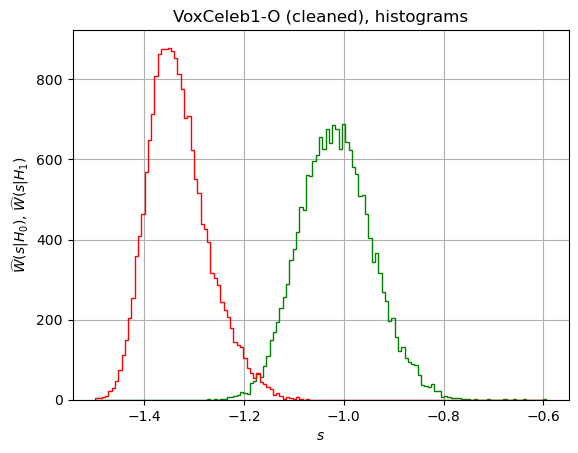

In [9]:
# Compute target and impostor histogram
tar_scores, imp_scores = tar_imp_hists(all_scores, all_labels)

# Plot histograms for target and impostor scores
min_scores = np.concatenate((tar_scores, imp_scores)).min()
max_scores = np.concatenate((tar_scores, imp_scores)).max()

hist(tar_scores, int(sqrt(len(tar_scores))), histtype='step', color='green', range=(min_scores, max_scores))
hist(imp_scores, int(sqrt(len(imp_scores))), histtype='step', color='red',   range=(min_scores, max_scores))
xlabel('$s$'); ylabel('$\widehat{W}(s|H_0)$, $\widehat{W}(s|H_1)$'); title('VoxCeleb1-O (cleaned), histograms'); grid(); show()

**5. Вычисление порогового значения, вероятности ошибки принятия решения, вероятностей ошибок первого и второго рода**

Выражаясь терминами *бинарной теории принятия решений* предположение о наличии таргет-пары при решении задачи распознавания диктора связывается с *нулевой гипотезой* – $H_0$, а предположение о наличии импостор-пары связывается с *альтернативной гипотезой* – $H_1$. Когда задача распознавания диктора рассматривается в качестве задачи верификации в системе возможно возникновение следующих ситуаций:

1. Пара сранения «эталон-тест» является таргет-парой, решение системы принимается в пользу таргет-пары – событие $(D_0, H_0)$. Подобную ситуацию называют *правильным положительным решением (true positive)*.

2. Пара сранения «эталон-тест» является таргет-парой, решение системы принимается в пользу импостор-пары – событие $(D_1, H_0)$. Подобную ситуацию называют *ложным отрицательным решением (false negative)*. Говорят, что в этом случае возникает *ошибка первого рода*.

3. Пара сранения «эталон-тест» является импостор-парой, решение системы принимается в пользу таргет-пары – событие $(D_0, H_1)$. Подобную ситуацию называют *ложным положительным решением (false positive)*. Говорят, что в этом случае возникает *ошибка второго рода*.

4. Пара сранения «эталон-тест» является импостор-парой, решение системы принимается в пользу импостор-пары – событие $(D_1, H_1)$. Подобную ситуацию называют *правильным отрицательным решением (true negative)*.

Как правило, перед принятием решения значение оценки сравнения эталона и теста представляется в виде *натурального логарифма отношения правдоподобия (LLR, log-likelihood ratio)*:

$$LLR = ln \left [ \frac{W(s|H_0)}{W(s|H_1)} \right ],$$ 

здесь $s$ – величина оценки сравнения эталона и теста, а $W(s|H_0)$ и $W(s|H_1)$ – плотности вероятностей, описывающие распределение оценок сравнения для таргет- и импостор-попыток. Обычно подобные плотности вероятностей рассматриваются в виде *одномерных гауссовских плотностей*, параметры математического ожидания и среднеквадратического отклонения которых оцениваются с использованием некоторого набора данных с помощью следующих математических формул:

$$m_{H_i} = \frac{1}{N_{H_i}}\sum_{n = 1}^{N_{H_i}}s_n, \sigma_{H_i} = \sqrt{\frac{1}{N_{H_i} - 1}\sum_{n = 1}^{N_{H_i}}(s_n - m_{H_i})^{2}}, i = 0, 1,$$

здесь $N_i$ – количество таргет-/импостор-пар в протоколе верификации, используемом для оценки параметров плотностей веротяностей $W(s|H_0)$ и $W(s|H_1)$. *В простейшем случае этот протокол может совпадать с тестовым протоколом, но ожидания по качеству работы системы распознавания диктора в этом случае будут завышенными!* Поэтому на практике протокол верификации для оценки параметров распределений выше выбирается отличным от протокола тестирования.

Для принятия автоматического решения биометрической системой требуется подобрать *величину порога принятия решения*. В случае, если значение $LLR$ для сравниваемой пары «эталон-тест» будет выше порога, решение биометрической системы будет принято в пользу таргет-пары и наоборот, если значение $LLR$ для сравниваемой пары «эталон-тест» будет ниже порога, решение биометрической системы будет принято в пользу импостор-пары.

Бинарная теория принятия решений говорит о том, что порог принятия решения может быть выбран несколькими различными способами: критерий максимального правдоподобия, критерий максимума апостериорной вероятности (критерий минимума вероятности ошибки), критерий Неймана-Пирсона, критерий Байеса и минимаксный критерий.

*Критерий максимального правдоподобия* предполагает, что априорные вероятности $P(H_0)$ и $P(H_1)$ выпадения таргет- и импостор-пар являются одинаковыми. Математически критерий может быть сформулирован следующим образом: если $LLR > 0$, то решение принимается в пользу таргет-пары и наоборот, если $LLR < 0$, то решение принимается в пользу импостор-пары. Величина порога принятия решения в этом случае равна 0.

*Критерий максимума апостериорной вероятности* является более общим, чем критерий максимального правдоподобия и учитывает возможность неравенства априорных вероятностей выпадения таргет- и импостор-пар. Математически критерий может быть сформулирован следующим образом: если $LLR > ln(P(H_1)/P(H_0))$, то решение принимается в пользу таргет-пары и наоборот, если $LLR < ln(P(H_1)/P(H_0))$, то решение принимается в пользу импостор-пары. Величина порога принятия решения в этом случае равна $ln(P(H_1)/P(H_0))$. Иногда рассматриваемый критерий называют *критерием минимума вероятности ошибки*, поскольку можно математически доказать, что рассматриваемый критерий следует из минимизации выражения для *вероятности ошибки системы принятия решения*: 

$$P_e = P(D_1, H_0) + P(D_0, H_1) = P(D_1|H_0)P(H_0) + P(D_0|H_1)P(H_1),$$

где $P(D_1, H_0)$ – вероятность события $(D_1, H_0)$, а $P(D_0, H_1)$ – вероятность события $(D_0, H_1)$. Вероятности $P(D_1|H_0)$ и $P(D_0|H_1)$ называют *вероятностями ошибок первого (FRR, false rejection rate)* и *второго рода (FAR, false acceptance rate)*.

*Критерий Неймана-Пирсона* предполагает, что одна из вероятностей ошибок, например, первого рода, строго задана. Величина порога принятия решения выбирается в точке, для которой вероятность другой ошибки, например, второго рода, будет минимальна. 

*Критерий Байеса* обобщает критерии, описанные выше. В его основе лежит минимизация *средней стоимости* или *байесовского риска*, который математически описывается следующим образом:

$$\overline{C} = C_{00}P(D_0|H_0)P(H_0) + C_{10}P(D_1|H_0)P(H_0) + C_{01}P(D_0|H_1)P(H_1) + C_{11}P(D_1|H_1)P(H_1),$$

где $C_{00}$, $C_{10}$, $C_{01}$ и $C_{11}$ представляют скалярные величины, описывающие стоимости, связанные с событиями $(D_0, H_0)$, $(D_1, H_0)$, $(D_0, H_1)$ и $(D_1, H_1)$ соответственно. Минимизация средней стоимости позволяет сформулировать критерий Байеса следующим образом: если $LLR > ln((C_{01} - C_{11})P(H_1)/[(C_{10} - C_{00})P(H_0)])$, то решение принимается в пользу таргет-пары и наоборот, если $LLR < ln((C_{01} - C_{11})P(H_1)/[(C_{10} - C_{00})P(H_0)])$, то решение принимается в пользу импостор-пары. Величина порога принятия решения в этом случае равна $ln((C_{01} - C_{11})P(H_1)/[(C_{10} - C_{00})P(H_0)])$.

При рассмотрении практических задач возможна ситуация, при которой априорные вероятности выпадения таргет- и импостор-пар являются неизвестными. В этом случае выбор порога принятия решения может быть выполнен с использованием *минимаксного критерия*. Выражение для среднего риска максимизируется по $P(H_0)$, а затем для найденного значения $P(H_0)$ минимизируется так, как в критерии Байеса.

В рамках настоящего пункта требуется выполнить следующие задания:

1. Вычислить логарифм отношение правдоподобия для всех оценок сравнения «эталон-тест» из рассматриваемого протокола тестирования. При решении данной задачи необходимо выполнить сортировку значений, в порядке возрастания, внутри одномерного массива, содержащего все оценки сравнения эталонов и тестов. Дополнительно рекомендуется синхронно с массивом выше сформировать одномерный массив, содержащий идеальную разметку сравнений эталонов и тестов.

2. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием критерия максимального правдоподобия и критерия максимума апостериорной вероятности (критерий минимума вероятности ошибки).

3. Вычислить пороговое значение, верость ошибки принятия решения, вероятность ошибки второга рода для заданной ошибки первого рода на основе оценок сравнения моделей с использованием критерия Неймана-Пирсона.

4. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода на основе оценок сравнения моделей с использованием критерия Байеса.

5. Вычислить пороговое значение, верость ошибки принятия решения, вероятности ошибок первого и второга рода, минимум максимума байесовского риска, а также вероятность таргет-пары на основе оценок сравнения моделей с использованием минимаксного критерий.

In [10]:
# Gaussian probability density function
gauss_pdf = lambda score, mu, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(score - mu)**2/(2*(abs(sigma) + 1e-10)**2))

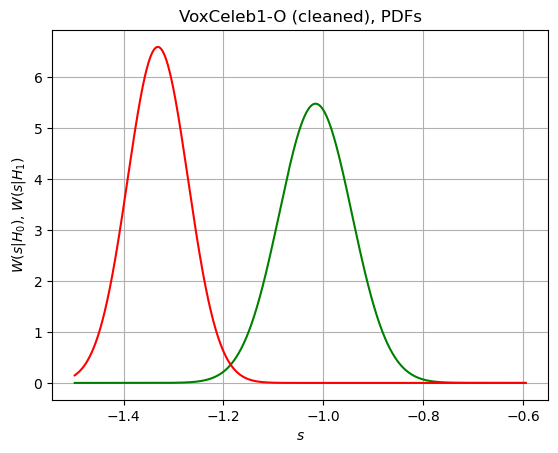

In [13]:
# Compute log-likelihood ratio
ground_truth_sort, all_scores_sort, tar_gauss_pdf, imp_gauss_pdf, LLR = llr(all_scores, all_labels, tar_scores, imp_scores, gauss_pdf)

# Plot PDFs for target and impostor scores
plot(all_scores_sort, tar_gauss_pdf, color='green')
plot(all_scores_sort, imp_gauss_pdf, color='red')
xlabel('$s$'); ylabel('$W(s|H_0)$, $W(s|H_1)$'); title('VoxCeleb1-O (cleaned), PDFs'); grid(); show()

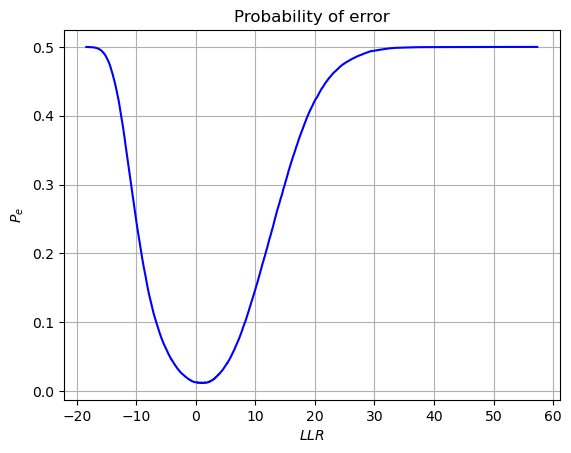

Threshold value:      0.957
False negative rate:  0.011
False positive rate:  0.013
Probability of error: 0.012


In [14]:
# Maximum-likelihood test and maximum a posteriori (MAP) test. MAP is the same as Minimum Probability of Error Test
P_Htar = 1/2 # prob. of target hypothesis

llr_thr_val, fnr_thr_val, fpr_thr_val, P_err_min = map_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar)

print('Threshold value:      {0:.3f}'.format(llr_thr_val))
print('False negative rate:  {0:.3f}'.format(fnr_thr_val))
print('False positive rate:  {0:.3f}'.format(fpr_thr_val))
print('Probability of error: {0:.3f}'.format(P_err_min))

In [18]:
# Neyman-Pearson test
fnr    = 1/4 # given prob. of Type I error P(Dimp|Htar), false negative rate (FNR)

llr_thr_val, fpr_thr_val = neyman_pearson_test(ground_truth_sort, LLR, tar_scores, imp_scores, fnr)

print('Threshold value:      {0:.3f}'.format(llr_thr_val))
print('False negative rate:  {0:.3f}'.format(fnr))
print('False positive rate:  {0:.3f}'.format(fpr_thr_val))

Threshold value:      8.811
False negative rate:  0.250
False positive rate:  0.000


In [40]:
# Bayes' test
P_Htar = 1/2 # prob. of target hypothesis
C00    = 0   # cost of event (Dtar, Htar)
C10    = 1   # cost of event (Dimp, Htar)
C01    = 1   # cost of event (Dtar, Himp)
C11    = 0   # cost of event (Dimp, Himp)

llr_thr_val, fnr_thr_val, fpr_thr_val, AC_val = bayes_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar, C00, C10, C01, C11)

print('Threshold value:         {0:.3f}'.format(llr_thr_val))
print('False negative rate:     {0:.3f}'.format(fnr_thr_val))
print('False positive rate:     {0:.3f}'.format(fpr_thr_val))
print('Minimum of average cost: {0:.3f}'.format(AC_val))

Threshold value:         0.000
False negative rate:     0.006
False positive rate:     0.020
Minimum of average cost: 0.013


In [39]:
# Minimax test
P_Htar_thr = np.linspace(0, 1, num=1000) # set of prob. of target hypothesis
C00        = 0                           # cost of event (Dtar, Htar)
C10        = 1                           # cost of event (Dimp, Htar)
C01        = 1                           # cost of event (Dtar, Himp)
C11        = 0                           # cost of event (Dimp, Himp)

llr_thr_val, fnr_thr_val, fpr_thr_val, AC_val, P_Htar_thr_val = minmax_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar_thr, C00, C10, C01, C11)

print('Threshold value:        {0:.3f}'.format(llr_thr_val))
print('False negative rate:    {0:.3f}'.format(fnr_thr_val))
print('False positive rate:    {0:.3f}'.format(fpr_thr_val))
print('Minmax of average cost: {0:.3f}'.format(AC_val))
print('Probability of Htar:    {0:.3f}'.format(P_Htar_thr_val))

Threshold value:        0.548
False negative rate:    0.008
False positive rate:    0.016
Minmax of average cost: 0.011
Probability of Htar:    0.366


/home/kirilabrosimov/PycharmProjects/study/sr_labs_book/lab4/exercises_blank.py:122: RuntimeWarning: divide by zero encountered in log
  thr = np.log(((C01 - C11)*p_h1)/((C10 - C00)*p_h0))


**6. Вычисление значения равновероятной ошибки**

Оценивать качество работы системы распознавания диктора визуально по наложению гистограмм для таргет- и импостор-оценок сравнения эталона и теста не очень удобно. Особенно тогда, когда количество сравниваемых системы очень большое. Поэтому можно воспользоваться некоторыми численными метриками автоматической оценки качества, например, вероятностью ошибки, как это было выполнено выше. В предположении, что априорные вероятности выпадения таргет- и импостор-пар сравнения эталонов и тестов являются одинаковыми, а также считая, что порог принятия решения выбран в точке, для которой вероятности ошибок первого и второго рода одинаковые, вероятность ошибки превращается *метрику равновероятной ошибки (EER, equal error rate)*.

Рассмотрим вычисление величины равновероятной ошибки для используемого протокола тестирования VoxCeleb1-O (cleaned).

In [36]:
# Compute Equal Error Rate
EER, _ = get_eer(tar_scores, imp_scores)

print('Equal Error Rate (EER): {0:.3f}%'.format(EER))

Equal Error Rate (EER): 1.180%


**7. Контрольные вопросы**
											
1. Как устроен протокол тестирования системы верификации?											
2. Что такое таргет- и импостор-пара?											
3. Какие подходы к сравнению дикторских моделей вам известны?
4. Что такое критерий принятия решения и какими они бывают (максимального правдоподобия, максимума апостериорной вероятности, Неймана-Пирсона, байесовский, минимаксный)?		
5. Что такое ошибки первого и второго рода и как вычислить их вероятности (FRR, false rejection rate, и FAR, false acceptance rate) в распознавании диктора?
6. Что такое равный уровень ошибок (EER, equal error rate)?											
7. Что такое кривая функционирования приемника (ROC, receiver operating characteristic) и кривая компромисса между ошибками детектирования (DET, detection error tradeoff)?

**8. Список литературы**

1. Hsu H.P. Schaum’s Ouline of Analog and Digital Communications. McGraw-Hill, 2003 ([ссылка](http://www.oasitech.it/upl/ese_schaum.pdf)).

2. Hsu H.P. Schaum’s Ouline of Theory and Problems of Probability, Random Variables, and Random Processes. McGraw-Hill, 1997 ([ссылка](http://webpages.iust.ac.ir/matashbar/teaching/schaum_probability.pdf)).